# Data Prep

## Import packages

In [4]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import pathlib
import os
import joblib
from glob import glob
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
%matplotlib inline

plt.style.use('seaborn-dark')

## Define global variables

In [7]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [2]:
BASE_DIR = '/content/drive/My Drive/Machine Learning/Data/Music Genre/'
GENRE_DIR = '/content/drive/My Drive/Machine Learning/Data/Music Genre/genres'
IMG_DIR = 'wave_to_image'
TRAIN_DATA_1D = 'train_1d.npy'
TEST_DATA_1D = 'test_1d.npy'
TRAIN_DATA_2D = 'train_2d.npy'
TEST_DATA_2D = 'test_2d.npy'
TRAIN_TARGET = 'y_train.npy'
TEST_TARGET = 'y_test.npy'
TRAIN_FILE = 'train'
VAL_FILE = 'val'
TRAIN_DATAGEN = 'train_datagen.pkl'
TEST_DATAGEN = 'test_datagen.pkl'
BATCH_SIZE = 30

## Load and clean data

## Data for 1D CNN

### Preprocess Data

In [3]:
def create_1d_dataframe(directory):
  audio_df = []
  for class_folder_name in os.listdir(directory):
    class_folder_path = os.path.join(directory, class_folder_name)
    for audio_path in glob(os.path.join(class_folder_path,'*wav')):
      tmp = pd.DataFrame([audio_path, class_folder_name]).T
      audio_df.append(tmp)

  audio_df = pd.concat(audio_df, axis = 0, ignore_index = True)
  audio_df.columns = ['audio_path','target_class']

  return audio_df


audio_df = create_1d_dataframe(GENRE_DIR)

In [4]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(audio_df['audio_path'], audio_df['target_class'], test_size = 0.2, random_state = 42)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

print(X_train.shape, X_test.shape)

(800,) (200,)


In [5]:
# encode target

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

t_train = to_categorical(y_train_enc)
t_test = to_categorical(y_test_enc)

### Create dataset

In [21]:
def convert_wav(df,n):
  y, sr = librosa.load(df[n], mono = True, duration = 15)
  mfcc = librosa.feature.mfcc(y = y, sr = sr)
  return mfcc

def create_dataset_1d(df):
  array_list = []
  for n in range(0, len(df)):
    y = convert_wav(df, n)
    array_list.append(y)

  return array_list
  

In [23]:
X_train = create_dataset_1d(X_train)
X_train = np.asarray(X_train)

In [24]:
X_test = create_dataset_1d(X_test)
X_test = np.asarray(X_test)

In [25]:
np.save(open(BASE_DIR + TRAIN_DATA_1D, 'wb'), X_train)
np.save(open(BASE_DIR + TEST_DATA_1D, 'wb'), X_test)
np.save(open(BASE_DIR + TRAIN_TARGET, 'wb'), t_train)
np.save(open(BASE_DIR + TEST_TARGET, 'wb'), t_test)

## Data for 2D CNN

In [ ]:
# convert audio file to mel spectrogram
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
n_mels = 128

for g in genres:
  pathlib.Path(f"{BASE_DIR + IMG_DIR}/{g}").mkdir(parents = True, exist_ok = True)
  for filename in os.listdir(f"{GENRE_DIR}/{g}"):
    songname = f"{GENRE_DIR}/{g}/{filename}"
    y, sr = librosa.load(songname, mono = True, duration = 5)
    ex_wav, _ = librosa.effects.trim(y)
    S = librosa.feature.melspectrogram(ex_wav, sr = sr)
    S_DB = librosa.power_to_db(S, ref = np.max)
    librosa.display.specshow(S_DB, sr = sr)
    
    plt.axis('off')
    plt.savefig(f"{BASE_DIR + IMG_DIR}/{g}/{filename[:-3].replace('.','')}.png")
    plt.clf()

In [275]:
# create dataframe
def create_dataframe(directory):
  images_df = []
  for class_folder_name in os.listdir(directory):
    class_folder_path = os.path.join(directory, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, '*png')):
      tmp = pd.DataFrame([image_path, class_folder_name]).T
      images_df.append(tmp)
  
  images_df = pd.concat(images_df, axis = 0, ignore_index = True)
  images_df.columns = ['image_path', 'target_class']
  
  return images_df

images_df = create_dataframe(BASE_DIR + IMG_DIR)

### Preprocess Data

In [276]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(images_df['image_path'], images_df['target_class'], random_state = 42, test_size = 0.2)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

print(X_train.shape, X_test.shape)

(800,) (200,)


### Resize and create dataset

In [277]:
IMG_SIZE = 128

def resize_image(df, n):
  im = cv2.imread(df[n])
  im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
  return im

def create_dataset(df, image_size):
  tmp = np.zeros((len(df), image_size, image_size, 3), dtype = 'float32')

  for n in range(0, len(df)):
    im = resize_image(df, n)
    tmp[n] = im

  print(f"image shape: {tmp.shape}")
  return tmp

In [278]:
X_train = create_dataset(X_train, IMG_SIZE)

image shape: (800, 128, 128, 3)


In [279]:
X_test = create_dataset(X_test, IMG_SIZE)

image shape: (200, 128, 128, 3)


In [280]:
# save processed data
np.save(open(BASE_DIR + TRAIN_DATA_2D, 'wb'), X_train)
np.save(open(BASE_DIR + TEST_DATA_2D, 'wb'), X_test)

# Build Model

## Import packages

In [86]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from sklearn.metrics import classification_report

## Load data

In [4]:
X_train_2d = np.load(open(BASE_DIR + TRAIN_DATA_2D, 'rb'))
X_test_2d = np.load(open(BASE_DIR + TEST_DATA_2D, 'rb'))

X_train_1d = np.load(open(BASE_DIR + TRAIN_DATA_1D, 'rb'))
X_test_1d = np.load(open(BASE_DIR + TEST_DATA_1D, 'rb'))

y_train = np.load(open(BASE_DIR + TRAIN_TARGET, 'rb'))
y_test = np.load(open(BASE_DIR + TEST_TARGET, 'rb'))

## Modeling

### 2D CNN

#### Initialize Variables

In [45]:
MODEL = '2d_cnn_model.h5'
ACC_2D = '2d_accuracy.png'
LOSS_2D = '2d_loss.png'
ACC_1D = '1d_accuracy.png'
LOSS_1D = '1d_loss.png'
EPOCHS = 100
LEARNING_RATE = 0.00025
BATCH_SIZE = 16
INPUT_SHAPE = (128,128,3)
FIRST_FILTER = 32
SECOND_FILTER = 32
THIRD_FILTER = 32
KERNEL = (3,3)
POOL_SIZE = (2,2)
CONV_DROPOUT = 0.25
FC_DROPOUT = 0.5

In [18]:
K.clear_session()

convnet = Sequential()

convnet.add(Conv2D(FIRST_FILTER, KERNEL, input_shape = INPUT_SHAPE))
convnet.add(BatchNormalization())
convnet.add(Activation('relu'))
convnet.add(Dropout(CONV_DROPOUT))
convnet.add(AveragePooling2D(pool_size = POOL_SIZE))


convnet.add(Conv2D(SECOND_FILTER, KERNEL))
convnet.add(BatchNormalization())
convnet.add(Activation('relu'))
convnet.add(Dropout(CONV_DROPOUT))
convnet.add(AveragePooling2D(pool_size = POOL_SIZE))

convnet.add(Conv2D(THIRD_FILTER, KERNEL))
convnet.add(BatchNormalization())
convnet.add(Activation('relu'))
convnet.add(Dropout(CONV_DROPOUT))
convnet.add(AveragePooling2D(pool_size = POOL_SIZE))

convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dense(32, activation = 'relu'))
convnet.add(Dropout(FC_DROPOUT))
convnet.add(Dense(16, activation = 'relu'))
convnet.add(Dropout(FC_DROPOUT))
convnet.add(Dense(10, activation = 'softmax'))

opt = Adam(lr = LEARNING_RATE)
convnet.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [19]:
mc = ModelCheckpoint(BASE_DIR + MODEL, monitor = 'val_loss', verbose = 0, save_best_only = True)

history = convnet.fit(X_train_2d, 
                      y_train,
                      verbose = 2,
                      epochs = EPOCHS,                    
                      callbacks = [mc],
                      validation_data = (X_test_2d, y_test))

Epoch 1/100
25/25 - 2s - loss: 3.1015 - accuracy: 0.1287 - val_loss: 2.7127 - val_accuracy: 0.1050
Epoch 2/100
25/25 - 1s - loss: 2.9142 - accuracy: 0.1250 - val_loss: 2.6767 - val_accuracy: 0.0750
Epoch 3/100
25/25 - 1s - loss: 2.7329 - accuracy: 0.1575 - val_loss: 2.6011 - val_accuracy: 0.0750
Epoch 4/100
25/25 - 1s - loss: 2.5831 - accuracy: 0.1488 - val_loss: 2.4110 - val_accuracy: 0.0750
Epoch 5/100
25/25 - 1s - loss: 2.4995 - accuracy: 0.1762 - val_loss: 2.3163 - val_accuracy: 0.0850
Epoch 6/100
25/25 - 1s - loss: 2.4898 - accuracy: 0.1800 - val_loss: 2.2273 - val_accuracy: 0.1450
Epoch 7/100
25/25 - 1s - loss: 2.5047 - accuracy: 0.1562 - val_loss: 2.1425 - val_accuracy: 0.2000
Epoch 8/100
25/25 - 1s - loss: 2.3368 - accuracy: 0.2025 - val_loss: 2.1433 - val_accuracy: 0.2700
Epoch 9/100
25/25 - 1s - loss: 2.3267 - accuracy: 0.1988 - val_loss: 2.0851 - val_accuracy: 0.2750
Epoch 10/100
25/25 - 1s - loss: 2.3014 - accuracy: 0.1887 - val_loss: 2.0996 - val_accuracy: 0.2900
Epoch 11/

In [20]:
convnet.evaluate(X_test_2d, y_test, steps = 16, verbose = 1)

16/16 [==============================] - 0s 5ms/step - loss: 1.3782 - accuracy: 0.5750


[1.3782304525375366, 0.574999988079071]

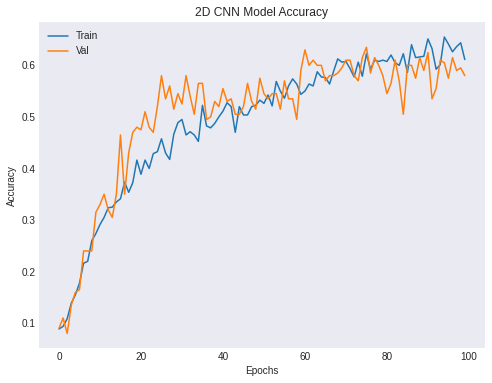

In [48]:
plt.figure(figsize = (8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.title('2D CNN Model Accuracy')
plt.savefig(BASE_DIR + ACC_2D, format = 'png')


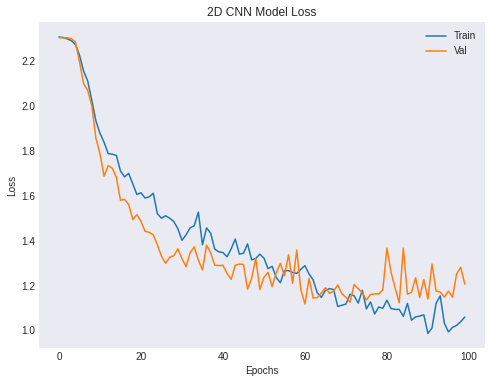

In [50]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.title('2D CNN Model Loss')
plt.savefig(BASE_DIR + LOSS_2D, format = 'png')

In [87]:
y_pred = convnet.predict(X_test_2d)
y_pred = np.argmax(y_pred, axis = 1)
clf = classification_report(y_test_enc, y_pred)
print(clf)

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        13
           1       0.47      0.33      0.39        27
           2       0.69      0.69      0.69        13
           3       0.71      0.88      0.79        25
           4       0.64      0.70      0.67        23
           5       0.56      0.45      0.50        20
           6       0.48      0.76      0.59        21
           7       0.75      0.14      0.24        21
           8       0.50      0.47      0.48        15
           9       0.61      0.50      0.55        22

    accuracy                           0.57       200
   macro avg       0.59      0.59      0.56       200
weighted avg       0.59      0.57      0.55       200



### 1D CNN + LSTM

#### Initialize variables

In [23]:
 SEQUENCE_MODEL = 'cnn_lstm_sequence.h5'
 EPOCHS = 100
 LR = 0.00025
 BATCH_SIZE = 16
 FILTER = 32
 KERNEL_SIZE = 4
 INPUT_SHAPE = (X_train_1d.shape[2], X_train_1d.shape[1]) # input shape of 1d ccn = (# samples, # timesteps, # features)
 POOL_SIZE = 2
 CONV_DROPOUT = 0.25
 FC_DROPOUT = 0.5

In [24]:
X_train_1d_reshape = X_train_1d.reshape(X_train_1d.shape[0], X_train_1d.shape[2], X_train_1d.shape[1])
X_test_1d_reshape = X_test_1d.reshape(X_test_1d.shape[0], X_test_1d.shape[2], X_test_1d.shape[1])

print(f"shape of mfcc : {X_train_1d.shape}")
print(f"reshaped mfcc to fit keras: {X_train_1d_reshape.shape}")

shape of mfcc : (800, 20, 646)
reshaped mfcc to fit keras: (800, 646, 20)


In [25]:
K.clear_session()

model = Sequential()

model.add(Conv1D(FILTER, KERNEL_SIZE, input_shape = INPUT_SHAPE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
# model.add(MaxPooling1D(pool_size = POOL_SIZE))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(Conv1D(FILTER, KERNEL_SIZE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
# model.add(MaxPooling1D(pool_size = POOL_SIZE))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(Conv1D(FILTER, KERNEL_SIZE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
# model.add(MaxPooling1D(pool_size = POOL_SIZE))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128, return_sequences = False))
model.add(Dropout(CONV_DROPOUT))


model.add(Dense(64, activation = 'relu'))
model.add(Dropout(FC_DROPOUT))
# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(FC_DROPOUT))
model.add(Dense(10, activation = 'softmax'))

opt = Adam(lr = LR)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [26]:
# es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)
mc = ModelCheckpoint(BASE_DIR + SEQUENCE_MODEL, monitor = 'val_loss', verbose = 0, save_best_only=True)
callbacks = [mc]

history = model.fit(X_train_1d_reshape,
                    y_train,
                    epochs = EPOCHS,                  
                    verbose = 2,
                    callbacks = callbacks,
                    validation_data = (X_test_1d_reshape, y_test))

Epoch 1/100
25/25 - 2s - loss: 2.3067 - accuracy: 0.0887 - val_loss: 2.3034 - val_accuracy: 0.0900
Epoch 2/100
25/25 - 1s - loss: 2.3047 - accuracy: 0.0938 - val_loss: 2.3025 - val_accuracy: 0.1100
Epoch 3/100
25/25 - 0s - loss: 2.2982 - accuracy: 0.1088 - val_loss: 2.3034 - val_accuracy: 0.0800
Epoch 4/100
25/25 - 1s - loss: 2.2907 - accuracy: 0.1388 - val_loss: 2.2990 - val_accuracy: 0.1350
Epoch 5/100
25/25 - 1s - loss: 2.2736 - accuracy: 0.1550 - val_loss: 2.2844 - val_accuracy: 0.1600
Epoch 6/100
25/25 - 1s - loss: 2.2259 - accuracy: 0.1775 - val_loss: 2.1963 - val_accuracy: 0.1650
Epoch 7/100
25/25 - 1s - loss: 2.1548 - accuracy: 0.2163 - val_loss: 2.0990 - val_accuracy: 0.2400
Epoch 8/100
25/25 - 1s - loss: 2.1109 - accuracy: 0.2200 - val_loss: 2.0693 - val_accuracy: 0.2400
Epoch 9/100
25/25 - 1s - loss: 2.0250 - accuracy: 0.2600 - val_loss: 2.0006 - val_accuracy: 0.2400
Epoch 10/100
25/25 - 1s - loss: 1.9333 - accuracy: 0.2738 - val_loss: 1.8559 - val_accuracy: 0.3150
Epoch 11/

In [ ]:
model.evaluate(X_test_1d_reshape, y_test, steps = 16)

16/16 [==============================] - 0s 10ms/step - loss: 1.2056 - accuracy: 0.5800


[1.2056421041488647, 0.5799999833106995]

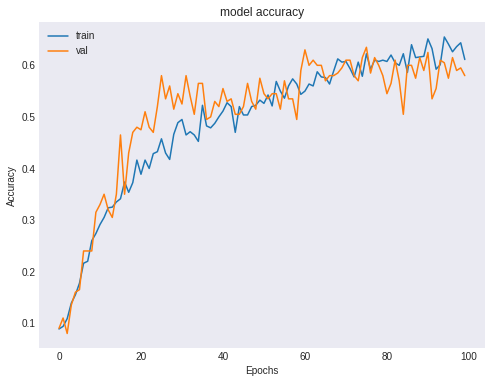

In [51]:
plt.figure(figsize = (8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('model accuracy')
plt.legend(['train','val'])
plt.savefig(BASE_DIR + ACC_1D, format = 'png')

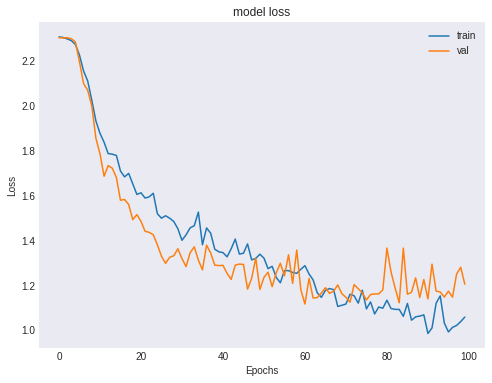

In [52]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('model loss')
plt.legend(['train','val'])
plt.savefig(BASE_DIR + LOSS_1D, format = 'png')

In [84]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_1d_reshape)
y_pred = np.argmax(y_pred, axis = 1)
clr = classification_report(y_test_enc,y_pred)

In [85]:
print(clr)

              precision    recall  f1-score   support

           0       0.27      0.46      0.34        13
           1       0.96      0.81      0.88        27
           2       0.33      0.46      0.39        13
           3       0.77      0.40      0.53        25
           4       0.48      0.43      0.45        23
           5       0.68      0.85      0.76        20
           6       0.76      0.62      0.68        21
           7       0.69      0.86      0.77        21
           8       0.40      0.40      0.40        15
           9       0.40      0.36      0.38        22

    accuracy                           0.58       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.61      0.58      0.58       200

